# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 

The loss function now is a cross-entropy loss, for a single data point it forms as:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j} \hspace{0.5in} \text{where} \hspace{0.5in} f(x_i; W) =  W x_i
$$

Consider of the numeric stability issues, it's better to have a normalization term $\log C = -\max_j f_j$ in the division of the softmax function:

$$
\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}
= \frac{Ce^{f_{y_i}}}{C\sum_j e^{f_j}}
= \frac{e^{f_{y_i} + \log C}}{\sum_j e^{f_j + \log C}}
$$

The loss of the entire data set with regularization term forms as:

$$
\begin{align}
L &= \frac{1}{N}\sum_iL_i + \lambda R(W)\\
&= \frac{1}{N}\sum_i\left(-\left(w_{y_i}^Tx_i+\log C\right)+\log\sum_j\exp\left(w_j^Tx_i+\log C\right)\right) + \frac{\lambda}{2}\sum_k\sum_lW_{k,l}^2\\
\end{align}
$$

The gradient of the loss function for a single data point without regularization term is:

$$
\begin{align}
\nabla_{w_{y_i}} L_i &= -x_i+\frac{\exp\left(w_{y_i}^Tx_i+\log C\right)}{\sum_j\exp\left(w_j^Tx_i+\log C\right)}x_i\\
&=-\frac{\sum_{j\neq y_i}\exp\left(w_j^Tx_i+\log C\right)}{\sum_j\exp\left(w_j^Tx_i+\log C\right)}x_i\\
\nabla_{w_{j}} L_i &= \frac{\exp\left(w_j^Tx_i+\log C\right)}{\sum_j\exp\left(w_j^Tx_i+\log C\right)}x_i
\end{align}
$$

In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.380654
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Because the accuracy of an random weight matrix which classifies the images into 10 classes is 10%, then the log softmax function is close to $\displaystyle-\log\frac{1}{10}.$*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.057818 analytic: -0.057818, relative error: 7.044087e-07
numerical: 0.016043 analytic: 0.016043, relative error: 2.495744e-06
numerical: 3.835465 analytic: 3.835465, relative error: 1.234337e-08
numerical: -0.601061 analytic: -0.601062, relative error: 8.216985e-08
numerical: -0.330275 analytic: -0.330275, relative error: 7.685813e-09
numerical: 2.721561 analytic: 2.721561, relative error: 1.660158e-09
numerical: -3.546576 analytic: -3.546576, relative error: 6.107912e-09
numerical: -1.811729 analytic: -1.811730, relative error: 3.784843e-08
numerical: -0.459017 analytic: -0.459017, relative error: 7.141842e-08
numerical: 3.864395 analytic: 3.864395, relative error: 1.819635e-08
numerical: 0.360173 analytic: 0.360173, relative error: 9.379433e-08
numerical: 2.403055 analytic: 2.403055, relative error: 3.081273e-08
numerical: 2.806226 analytic: 2.806226, relative error: 2.915318e-09
numerical: -1.107608 analytic: -1.107608, relative error: 6.558224e-09
numerical: -2.084383

From another perspective, softmax function compute the probability of each sample in all class:

$$
p\left(y_i=k\mid x_i;w\right)=\frac{\exp\left(w_k^Tx_i+\log C\right)}{\sum_j\exp\left(w_j^Tx_i+\log C\right)}
$$

The loss function can be written as:

$$
\begin{align}
L&=-\frac{1}{N}\left[\sum_{i=1}^N\sum_{j=1}^C1\{y_i=j\}\log\left(\frac{\exp\left(w_k^Tx_i+\log C\right)}{\sum_j\exp\left(w_j^Tx_i+\log C\right)}\right)\right]+\frac{\lambda}{2}\sum_{k=1}^D\sum_{l=1}^Cw_{k,l}^2\\
&=-\frac{1}{N}\left[\sum_{i=1}^N\sum_{j=1}^C1\{y_i=j\}\log\left(p\left(y_i=k\mid x_i;w\right)\right)\right]+\frac{\lambda}{2}\sum_{k=1}^D\sum_{l=1}^Cw_{k,l}^2\\
\end{align}
$$

Then the gradient is:

$$
\nabla_{w_j}L=-\frac{1}{N}\sum_{i=1}^N[x_i(1\{y_i=j\}-p\left(y_i=k\mid x_i;w\right))]+\lambda w_j
$$

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.380654e+00 computed in 0.141194s
vectorized loss: 2.380654e+00 computed in 0.004839s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
from itertools import product
for lr, rs in product(learning_rates, regularization_strengths):
    sm = Softmax()
    loss_hist = sm.train(X_train, y_train, learning_rate=lr, reg=rs,
                         num_iters=1500, verbose=True)
    y_train_pred = sm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = sm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, rs)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = sm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 778.940626
iteration 100 / 1500: loss 285.381676
iteration 200 / 1500: loss 105.751914
iteration 300 / 1500: loss 40.018756
iteration 400 / 1500: loss 15.913623
iteration 500 / 1500: loss 7.169015
iteration 600 / 1500: loss 3.920216
iteration 700 / 1500: loss 2.739906
iteration 800 / 1500: loss 2.331901
iteration 900 / 1500: loss 2.144304
iteration 1000 / 1500: loss 2.102148
iteration 1100 / 1500: loss 2.113951
iteration 1200 / 1500: loss 2.039363
iteration 1300 / 1500: loss 2.080034
iteration 1400 / 1500: loss 2.106774
iteration 0 / 1500: loss 1529242.425188


cs231n/classifiers/softmax.py:86: RuntimeWarning: divide by zero encountered in log
  Margin = np.log(Probability)
cs231n/classifiers/softmax.py:89: RuntimeWarning: invalid value encountered in multiply
  Mask_Margin = Mask_y * Margin


iteration 100 / 1500: loss nan


cs231n/classifiers/softmax.py:90: RuntimeWarning: overflow encountered in double_scalars
  loss = -np.sum(Mask_Margin) / num_train + 0.5*reg*np.sum(W*W)
cs231n/classifiers/softmax.py:90: RuntimeWarning: overflow encountered in multiply
  loss = -np.sum(Mask_Margin) / num_train + 0.5*reg*np.sum(W*W)


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan


cs231n/classifiers/softmax.py:94: RuntimeWarning: overflow encountered in multiply
  dW = -X.T.dot(dProbability) / num_train + reg*W


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 771.497124
iteration 100 / 1500: loss 6.859397
iteration 200 / 1500: loss 2.158726
iteration 300 / 1500: loss 2.063420
iteration 400 / 1500: loss 2.058667
iteration 500 / 1500: loss 2.090075
iteration 600 / 1500: loss 2.102466
iteration 700 / 1500: loss 2.093505
iteration 800 / 1500: loss 2.078734
iteration 900 / 1500: loss 2.089915
iteration 1000 / 1500: loss 2.003685
iteration 1100 / 1500: loss 2.155332
iteration 1200 / 1500: loss 2.130461
iteration 1300 / 1500: loss 2.097626
iteration 1400 / 1500: loss 2.119495
iteration 0 / 1500: loss 1551567.186520
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iterati

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.333000


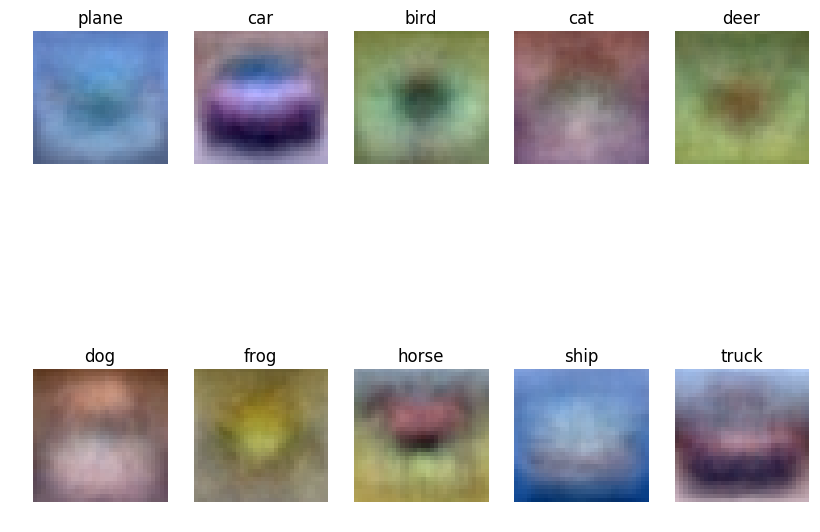

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])